### ¿Qué es un árbol de conexión en WDF?

En una red analógica, los elementos están interconectados de forma compleja. En WDF, para que el sistema sea:
- **Causal**
- **Pasivo**
- **Computacionalmente viable (sin ciclos algebraicos)**

...se representa como un **árbol binario dirigido**. Esto nos permite calcular las ondas incidentes y reflejadas en orden secuencial, sin retroalimentaciones algebraicas.

Este árbol tiene:
- Un **nodo raíz** (usualmente una fuente o puerto de entrada).
- **Nodos hijos** que propagan y reciben ondas.
- **Adaptadores** como nodos intermedios.


### Principales reglas para que un árbol WDF funcione:

1. **Solo un camino entre cualquier par de nodos** (es un árbol, no un grafo cíclico).
2. **Todos los elementos deben tener una resistencia de puerto definida**.
3. **El adaptador raíz debe ser *adaptable***, es decir, puede calcular su resistencia de puerto a partir de sus ramas.

Esto garantiza que se puedan calcular correctamente las ondas \( a \) y \( b \) en orden sin bucles.


In [4]:
    import numpy as np
    from pywdf.core.wdf import Resistor, Capacitor, SeriesAdaptor, IdealVoltageSource
    from pywdf.core.circuit import Circuit

    # Parámetros
    fs = 44100
    C_val = 1e-6
    cutoff = 1000
    R_val = 1.0 / (2 * np.pi * C_val * cutoff)

    # Crear componentes
    R = Resistor(R_val)
    C = Capacitor(C_val, fs)
    S = SeriesAdaptor(R, C)
    Vs = IdealVoltageSource(S)

    # Construcción del árbol: Vs es la raíz
    circuit = Circuit(source=Vs, root=Vs, output=C)
    circuit.fs = fs  



### ¿Cómo sé que mi árbol está bien construido?

1. Cada nodo se conecta **una sola vez** como hijo.
2. La clase `Circuit` puede recorrer el árbol sin errores.
3. Las ondas se propagan sin loops algebraicos.

Veamos la estructura y algunas propiedades:


In [5]:
print("Raíz:", type(circuit.root).__name__)
print("Hijos del adaptador Serie:", type(S.p1).__name__, type(S.p2).__name__)
print("Elemento de salida:", type(circuit.output).__name__)


Raíz: IdealVoltageSource
Hijos del adaptador Serie: Resistor Capacitor
Elemento de salida: Capacitor


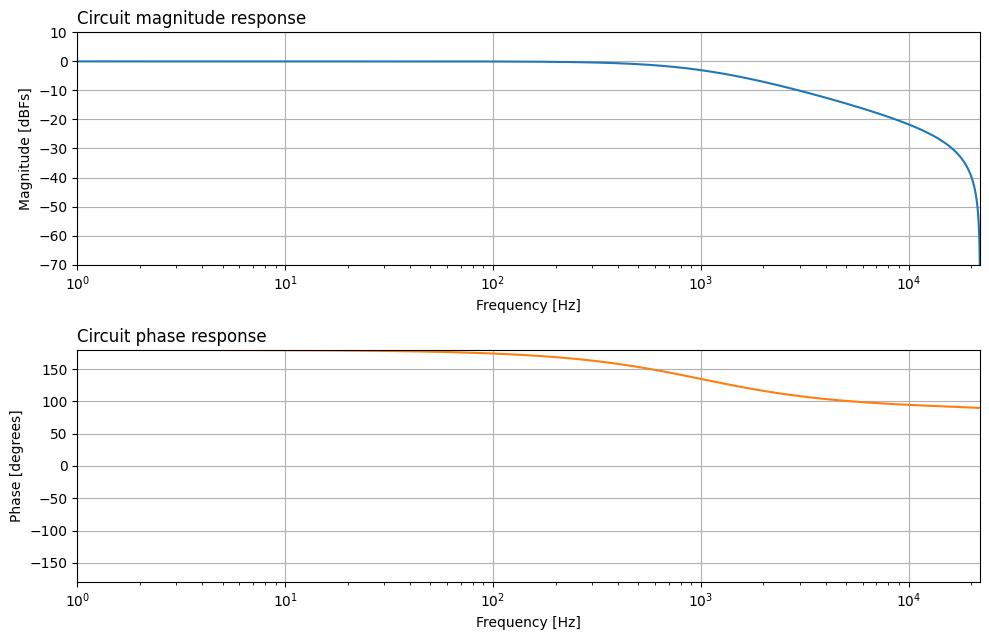

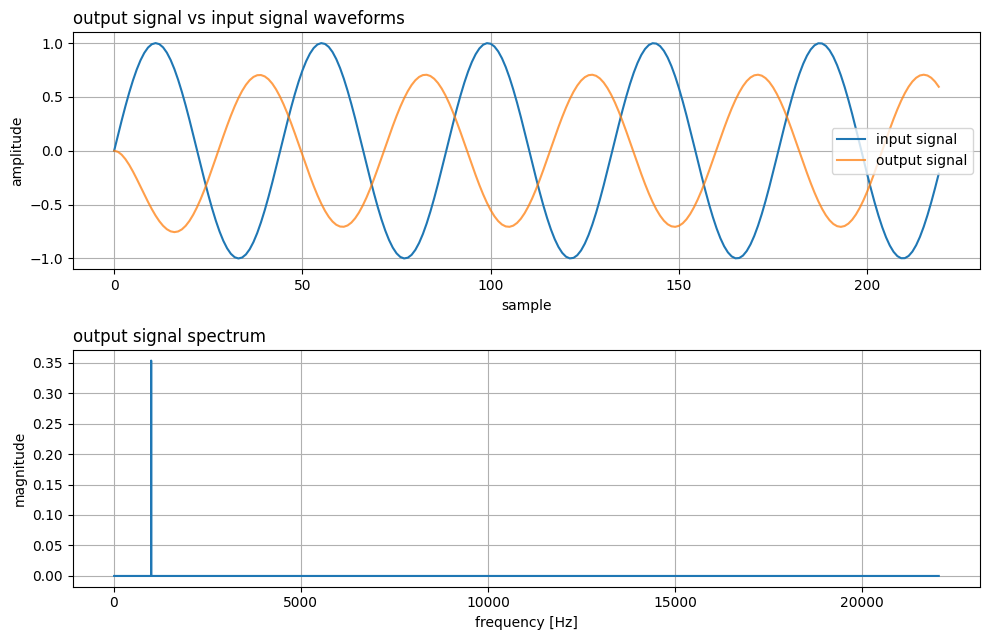

In [6]:
circuit.plot_freqz()
circuit.AC_transient_analysis(freq=1000, amplitude=1.0, t_ms=5)


Un nodo es **adaptable** si su resistencia de puerto puede calcularse directamente a partir de los elementos que conecta.

Esto es esencial para que el árbol funcione correctamente, porque:

- Cada nodo (por ejemplo, un adaptador serie/paralelo) necesita conocer su propia \( R_p \) para propagar correctamente las ondas.
- Si un nodo no puede calcular su \( R_p \), el sistema entra en ambigüedad algebraica (ciclos sin retardo).

**Ejemplo**:
- Un `SeriesAdaptor` es adaptable si ambos hijos tienen \( R_p \) definidos.
- Un circuito es **totalmente adaptable** si:
  - Todos los elementos tienen \( R_p \).
  - Todos los adaptadores pueden calcular su \( R_p \).
  - El **nodo raíz también es adaptable**.


In [7]:
# Verificación explícita
print("Adaptador Serie - Rp:", S.Rp)
print("Resistencia total esperada:", R_val + C.Rp)
print("Adaptador es adaptable:", np.isclose(S.Rp, R_val + C.Rp))


Adaptador Serie - Rp: 170.49281157262098
Resistencia total esperada: 170.49281157262098
Adaptador es adaptable: True


In [8]:
# Verificar que todas las impedancias se propagan hacia arriba correctamente
print("Impedancia del capacitor (Rp):", C.Rp)
print("Impedancia del resistor (Rp):", R.Rp)
print("Impedancia del adaptador (Rp):", S.Rp)
print("Impedancia de la fuente (Vs):", Vs.next.Rp)


Impedancia del capacitor (Rp): 11.337868480725623
Impedancia del resistor (Rp): 159.15494309189535
Impedancia del adaptador (Rp): 170.49281157262098
Impedancia de la fuente (Vs): 170.49281157262098


❌ Si un nodo no puede calcular su resistencia de puerto, el árbol falla.

Por ejemplo:
- Si un adaptador conecta una rama no adaptable (como una fuente ideal) sin tener resistencias a ambos lados, se rompe el cálculo.

✅ Por eso, los árboles deben diseñarse de forma que:
- Siempre haya **retardos suficientes** (capacitor o inductor).
- Siempre haya **R_p definidas hacia arriba**.

En modelos grandes (como amplificadores con múltiples nodos), se usan métodos automatizados para **resolver adaptabilidad global**.


### ✅ Resumen

- Construimos un árbol completo con resistores, capacitores y una fuente.
- Verificamos que todos los nodos son adaptables.
- Probamos la respuesta en frecuencia y transitoria.
- Confirmamos la importancia de las resistencias de puerto \( R_p \) y de evitar ciclos sin retardo.

---

📦 En el próximo notebook `06_Filtros_Completos_RC_RL.ipynb`, construiremos filtros reales completos (LowPass y HighPass) usando esta misma lógica y compararemos sus respuestas contra la teoría y el plugin VST en JUCE.
